<a href="https://colab.research.google.com/github/iBalag/games-with-nn/blob/master/HotdogOrNot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout

from google.colab import files

In [0]:
# Download train data
!wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
!unzip -q "train.zip"

train_folder = "train_kaggle/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

# Download test data
!wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
!unzip -q "test.zip"

test_folder = "test_kaggle/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

In [0]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available!

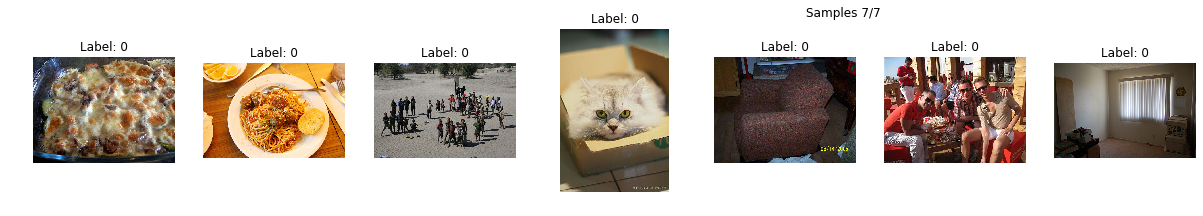

In [4]:
import re

class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.root_folder = folder        
        self.file_names = os.listdir(self.root_folder)
                                
    def __len__(self):
        return len(self.file_names)
        
    def __getitem__(self, index):        
        
        file_name = self.file_names[index]      
        full_name = os.path.join(self.root_folder, file_name)
        
        y = 0
        if re.match(r"^(frankfurter|chili\-dog|hotdog)", file_name):
            y = 1
        
        img = Image.open(full_name)
        
        if self.transform:
            img = self.transform(img)

        return img, y, file_name

      
def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))    
        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

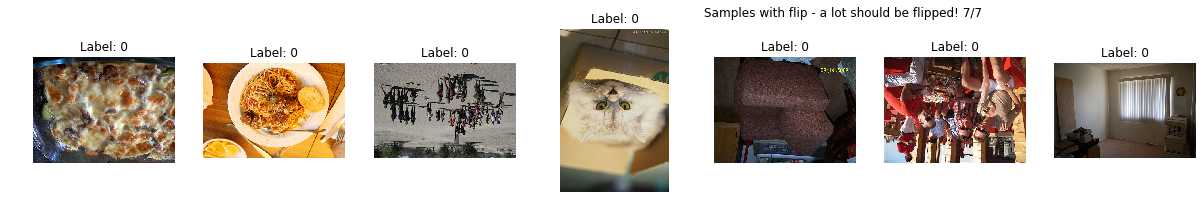

In [5]:
# Let's make sure transforms work!
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.9))

visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

In [0]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [0]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,sampler=val_sampler)

# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [0]:
def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        scheduler.step()
        print('Epoch:', epoch,'LR:', scheduler.get_lr())
      
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y, img_name) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
    
    
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode    
    correct = 0
    total = 0
    for data in val_loader:
        images, labels, img_name = data
        images_gpu = images.to(device)
        labels_gpu = labels.to(device)
        
        outputs = model(images_gpu)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels_gpu.size(0)
        correct += (predicted == labels_gpu).sum().item()
    
    return correct / total

In [0]:
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    
    # TODO: Process it to return dict of class index to name
    return { int(k): v[-1] for k, v in classes.items()}
 
resnet18_classes = load_imagenet_classes()

In [10]:
import random

indexes = []
for i in range(10):
    index = random.randrange(0, train_dataset.__len__())
    indexes.append(index)
    
indexes

[494, 1366, 4413, 3182, 3591, 1804, 3823, 2584, 3077, 366]

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 47261018.84it/s]


[261, 937, 5, 544, 828, 227, 283, 960, 39, 737]

('pets_722.jpg',
 'food_5783.jpg',
 'food_5200.jpg',
 'frankfurter_7085.jpg',
 'food_6184.jpg',
 'pets_356.jpg',
 'pets_758.jpg',
 'chili-dog_8152.jpg',
 'frankfurter_6952.jpg',
 'hotdog_9708.jpg')

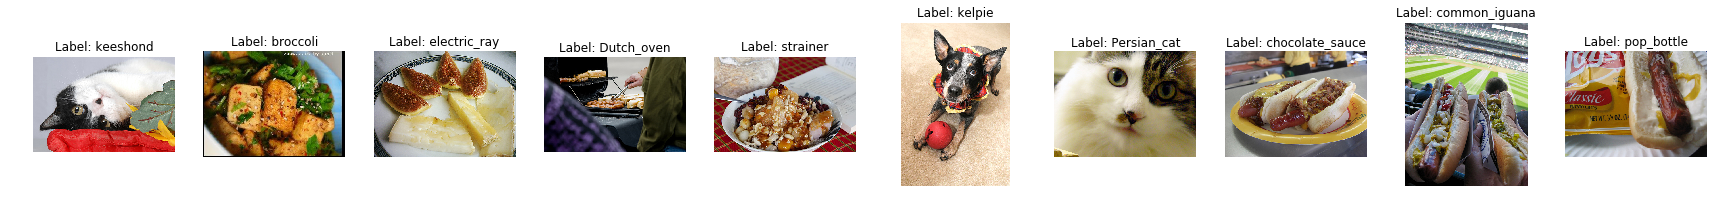

In [11]:
model = models.resnet18(pretrained=True)

#plt.figure(figsize=(count*3,3))
subset = torch.utils.data.Subset(train_dataset, indexes)

subset_loader = torch.utils.data.DataLoader(subset, batch_size=10)

predicted_list = []
images = []
for data in subset_loader:
    img, y, file_name = data    
    outputs = model(img)
    _, predicted = torch.max(outputs.data, 1)
    predicted_list += predicted.tolist()
    images = file_name
    
display(predicted_list)
display(images)

plt.figure(figsize=(10*3,3))

for i, index in enumerate(predicted_list):
    model_lable = resnet18_classes[index]
    img_path = os.path.join(train_folder, images[i])
    
    image = Image.open(img_path)
    
    plt.subplot(1,10,i+1)
    plt.title("Label: %s" % model_lable)
    plt.imshow(image)
    plt.grid(False)
    plt.axis('off')  

In [38]:
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.type(torch.cuda.FloatTensor)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
sched = StepLR(optimizer, step_size=4, gamma=0.3)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer,sched, 20)


Epoch: 0 LR: [0.01]
Average loss: 0.245090, Train accuracy: 0.896009, Val accuracy: 0.942391
Epoch: 1 LR: [0.01]
Average loss: 0.157860, Train accuracy: 0.946783, Val accuracy: 0.939130
Epoch: 2 LR: [0.01]
Average loss: 0.170370, Train accuracy: 0.937551, Val accuracy: 0.943478
Epoch: 3 LR: [0.0009]
Average loss: 0.122948, Train accuracy: 0.952484, Val accuracy: 0.932609
Epoch: 4 LR: [0.003]
Average loss: 0.134600, Train accuracy: 0.951670, Val accuracy: 0.945652
Epoch: 5 LR: [0.003]
Average loss: 0.110674, Train accuracy: 0.956557, Val accuracy: 0.946739
Epoch: 6 LR: [0.003]
Average loss: 0.130455, Train accuracy: 0.951127, Val accuracy: 0.944565
Epoch: 7 LR: [0.00027]
Average loss: 0.112076, Train accuracy: 0.955200, Val accuracy: 0.947826
Epoch: 8 LR: [0.0009]
Average loss: 0.111241, Train accuracy: 0.956286, Val accuracy: 0.941304
Epoch: 9 LR: [0.0009]
Average loss: 0.111294, Train accuracy: 0.959001, Val accuracy: 0.941304
Epoch: 10 LR: [0.0009]
Average loss: 0.117003, Train accur

In [0]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    predictions = []
    ground_truth = []
    
    dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=32,sampler=SubsetSampler(indices), num_workers=0)    
    for i_step, (x, y, img_name) in enumerate(dataset_loader):         
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        output = model(x_gpu)    
        _, prediction = torch.max(output, 1)
        predictions += prediction.tolist()
        ground_truth += y.tolist()
       
    return predictions, ground_truth

predictions, ground_truth = evaluate_model(model, train_dataset, val_indices)

In [0]:
TP = 0
TN = 0
FP = 0
FN = 0

true_positive_indices = []
false_positive_indices = []
false_negatives_indices = []

for i in range(len(predictions)):
    if predictions[i] == 1:
        if predictions[i] == ground_truth[i]:
            TP = TP + 1
            true_positive_indices.append(val_indices[i])
        else:
            FP = FP + 1
            false_positive_indices.append(val_indices[i])
        
    if predictions[i] == 0:
        if predictions[i] == ground_truth[i]:
            TN = TN + 1
        else:
            FN = FN + 1
            false_negatives_indices.append(val_indices[i])

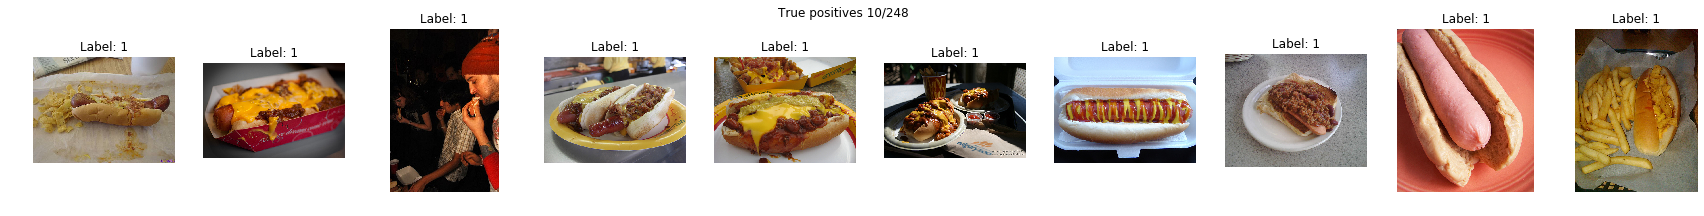

In [41]:
visualize_samples(orig_dataset, true_positive_indices, "True positives")

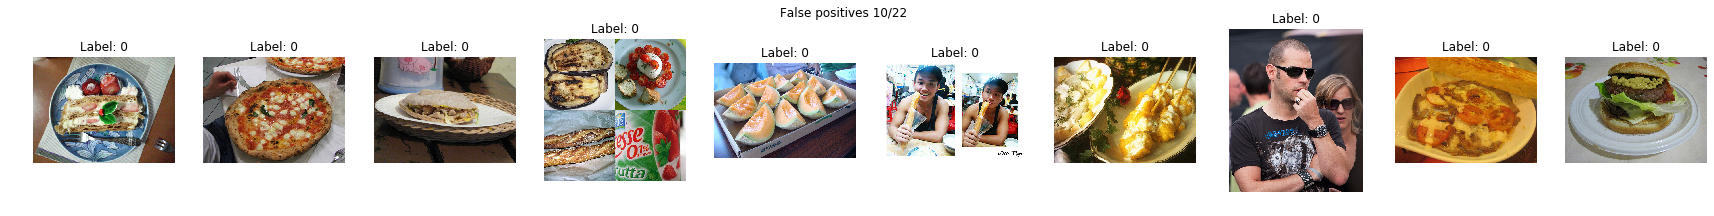

In [42]:
visualize_samples(orig_dataset, false_positive_indices, "False positives")

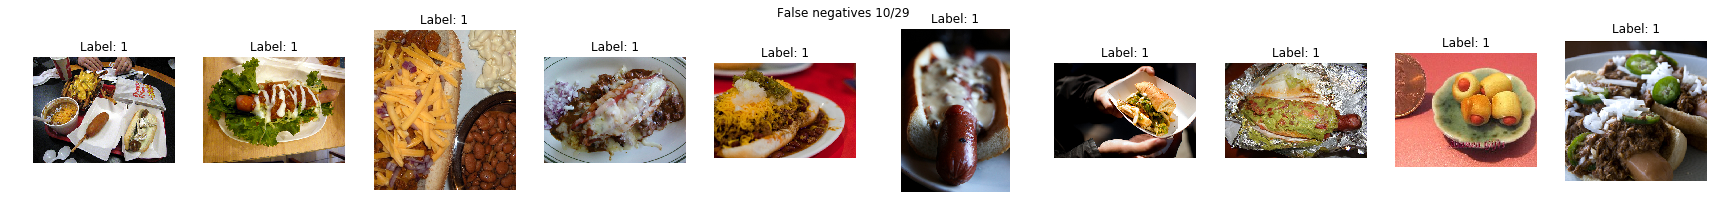

In [43]:
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")

In [44]:
import sklearn.metrics as metrics

def binary_classification_metrics(prediction, ground_truth):
    precision = metrics.precision_score(ground_truth, prediction)
    recall = metrics.recall_score(ground_truth, prediction)    
    f1 = metrics.f1_score(ground_truth, prediction)
    
    return precision, recall, f1

precision, recall, f1 = binary_classification_metrics(predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.907, P: 0.919, R: 0.895


In [0]:
import pandas as pd

predictions = {}
for x, y, img in test_loader:    
    x_gpu = x.to(device)
    prediction = model(x_gpu)
  
    _, indices = torch.max(prediction, 1)

    pred_dict = dict(zip(img, indices.tolist()))
    predictions.update(pred_dict)

predictions = sorted(predictions.items())

df = pd.DataFrame(predictions, columns=["image_id", "label"])
df.to_csv("/content/hotdog_subm.csv", index=False)